In [171]:
import pandas as pd
import numpy as np

import torch

In [172]:
class LogisticRegression(torch.nn.Module):
    
    def __init__(self, n_features, l1=0, l2=0):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(n_features, 1)
        torch.nn.init.uniform_(self.linear.weight)
        self.sigmoid = torch.nn.Sigmoid()
        self.l1 = l1
        self.l2 = l2
    
    def forward(self, x):
        output = self.linear(x)
        output = self.sigmoid(output)
        return output

    def compile(self, optimizer='Adam', learning_rate=0.01):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)


    def train(self, x, y, epochs=1000):
        
        criterion = torch.nn.BCELoss()
        
        for epoch in range(epochs):
            outputs = self(x)
            loss = criterion(outputs.squeeze(), y)
            
            l1_regularization = torch.tensor(0.0)
            for parameter in self.parameters():
                l1_regularization += torch.norm(parameter, 1)
                
            l2_regularization = torch.tensor(0.0)
            for parameter in self.parameters():
                l2_regularization += torch.norm(parameter, 2)

            loss += self.l1 * l1_regularization + self.l2 * l2_regularization

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if (epoch+1)%100==0:
                print("Epoch [{}/{}], loss:{}".format(epoch+1, epochs, loss.item()))

    def predict(self, x):
        with torch.no_grad():
            y_pred = self(x)
            y_pred_proba = torch.sigmoid(y_pred)
            y_pred_proba = torch.column_stack((1-y_pred_proba, y_pred_proba))
        return y_pred_proba

In [173]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [174]:
%%time
# Generate a sample dataset
X, y = make_classification(n_samples=10000, n_features=5, n_classes=2, random_state=666)

features = [ "f{}".format(i) for i in range(X.shape[1])]
label = 'target'

df = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1)
df.columns = features + [label]

X = df[features]
y = df[label]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

# y_train = pd.DataFrame(y_train)
# y_test = pd.DataFrame(y_test)

CPU times: user 8.4 ms, sys: 1.41 ms, total: 9.81 ms
Wall time: 8.22 ms


In [175]:
X_train.index

Index([4320, 5528, 3552, 3142, 8230, 2168, 3192, 5470, 7270, 3326,
       ...
       8767, 2785, 8755,  222, 1115, 1469, 8262, 2878, 7597, 6380],
      dtype='int64', length=8000)

In [189]:
# Standardize the features
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [190]:
X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train.columns, index=X_train.index)
X_test_normalized = pd.DataFrame(X_train_normalized, columns=X_test.columns, index=X_test.index)

In [191]:
X_train_tensor = torch.tensor(X_train_normalized.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_normalized.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [198]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [199]:
n_features = len(features)
model = LogisticRegression(n_features)

model.compile(learning_rate=0.001)

In [200]:
model.train(X_train_tensor, y_train_tensor)

Epoch [100/1000], loss:0.3581717610359192
Epoch [200/1000], loss:0.31948548555374146
Epoch [300/1000], loss:0.2924129366874695
Epoch [400/1000], loss:0.27292919158935547
Epoch [500/1000], loss:0.2586458921432495
Epoch [600/1000], loss:0.2479838877916336
Epoch [700/1000], loss:0.23988622426986694
Epoch [800/1000], loss:0.23363721370697021
Epoch [900/1000], loss:0.2287442535161972
Epoch [1000/1000], loss:0.22486278414726257


In [201]:
y_pred_proba = model.predict(X_test_tensor)

In [202]:
y_pred_proba

tensor([[0.4697, 0.5303],
        [0.2714, 0.7286],
        [0.2691, 0.7309],
        ...,
        [0.3072, 0.6928],
        [0.2700, 0.7300],
        [0.2695, 0.7305]])

In [203]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 1.0430, -0.3832,  0.9434,  1.0442,  0.1195]])),
             ('linear.bias', tensor([0.2182]))])

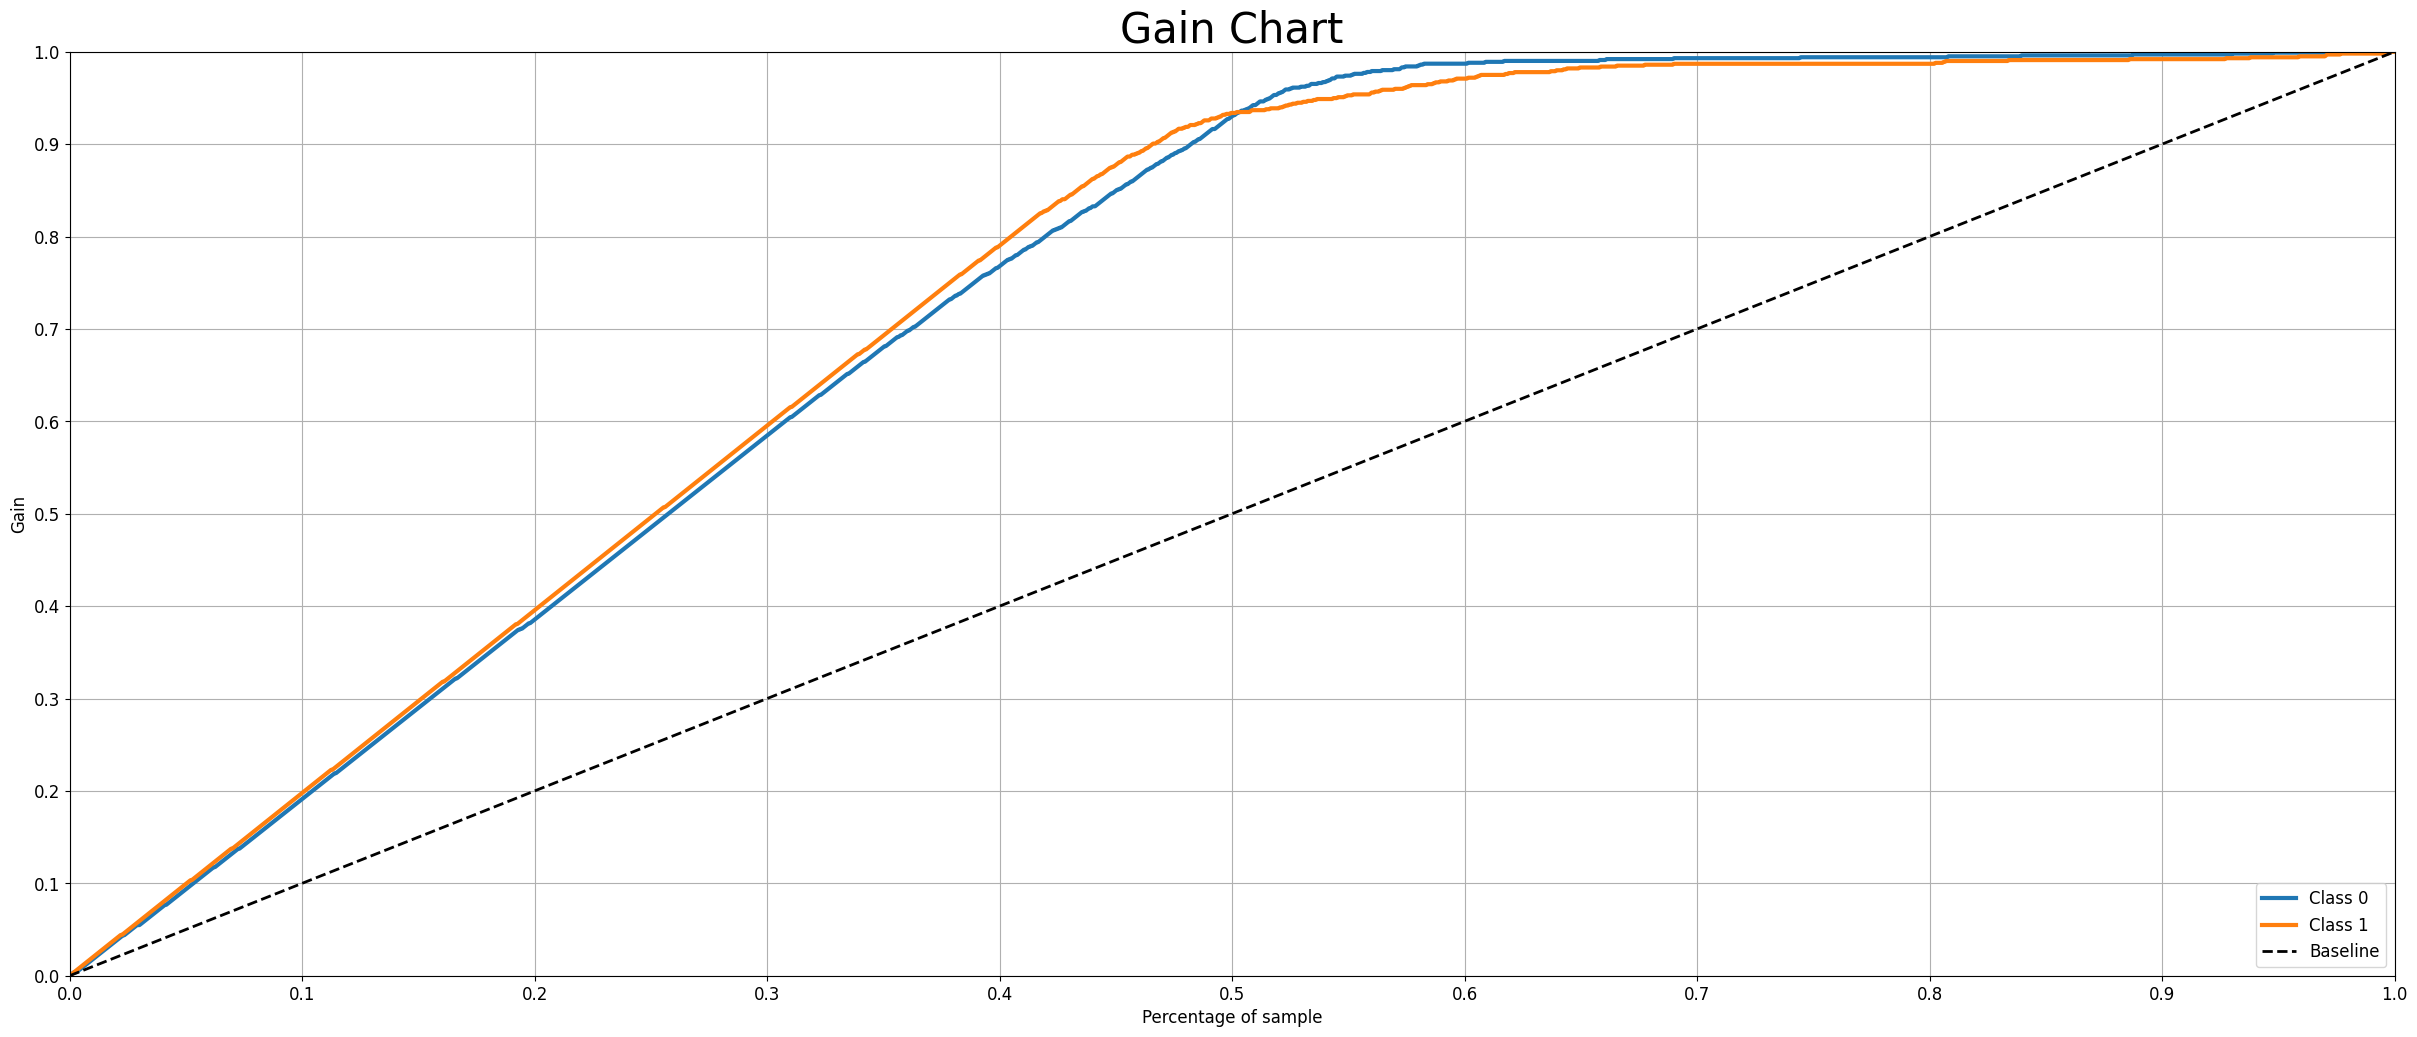

In [204]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_cumulative_gain(
    y_test,
    y_pred_proba,
    figsize=(30,12),
    title_fontsize=20,
    text_fontsize=12
)

plt.xlim([0,1])
plt.ylim([0,1])
plt.xticks(np.arange(0,1.1,step=0.1))
plt.yticks(np.arange(0,1.1,step=0.1))
plt.title("Gain Chart", size=30),
plt.rc('lines', linewidth=1.5, color='r')
plt.show()

In [186]:
import statsmodels.api as sm

logit_model = sm.Logit(y_train, sm.add_constant(X_train))
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.206469
         Iterations 27
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7995
Method:                           MLE   Df Model:                            4
Date:                Sat, 06 Jan 2024   Pseudo R-squ.:                  0.7021
Time:                        10:36:13   Log-Likelihood:                -1651.8
converged:                       True   LL-Null:                       -5545.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1704      0.047      3.652      0.000       0.079       0.262
f0             1.6938   2.45

In [187]:
result.predict(sm.add_constant(X_test))

6330    0.081383
7508    0.997434
6876    0.999995
849     0.947155
3624    0.084387
          ...   
6402    0.999248
4012    0.999999
4799    0.972738
1389    0.999468
2310    0.999846
Length: 2000, dtype: float64

In [188]:
y_pred_proba = np.column_stack( (1-result.predict(sm.add_constant(X_test)), result.predict(sm.add_constant(X_test))))

In [146]:
y_pred_proba

array([[9.18617410e-01, 8.13825900e-02],
       [2.56598753e-03, 9.97434012e-01],
       [4.78517910e-06, 9.99995215e-01],
       ...,
       [2.72618695e-02, 9.72738130e-01],
       [5.31503030e-04, 9.99468497e-01],
       [1.54456943e-04, 9.99845543e-01]])

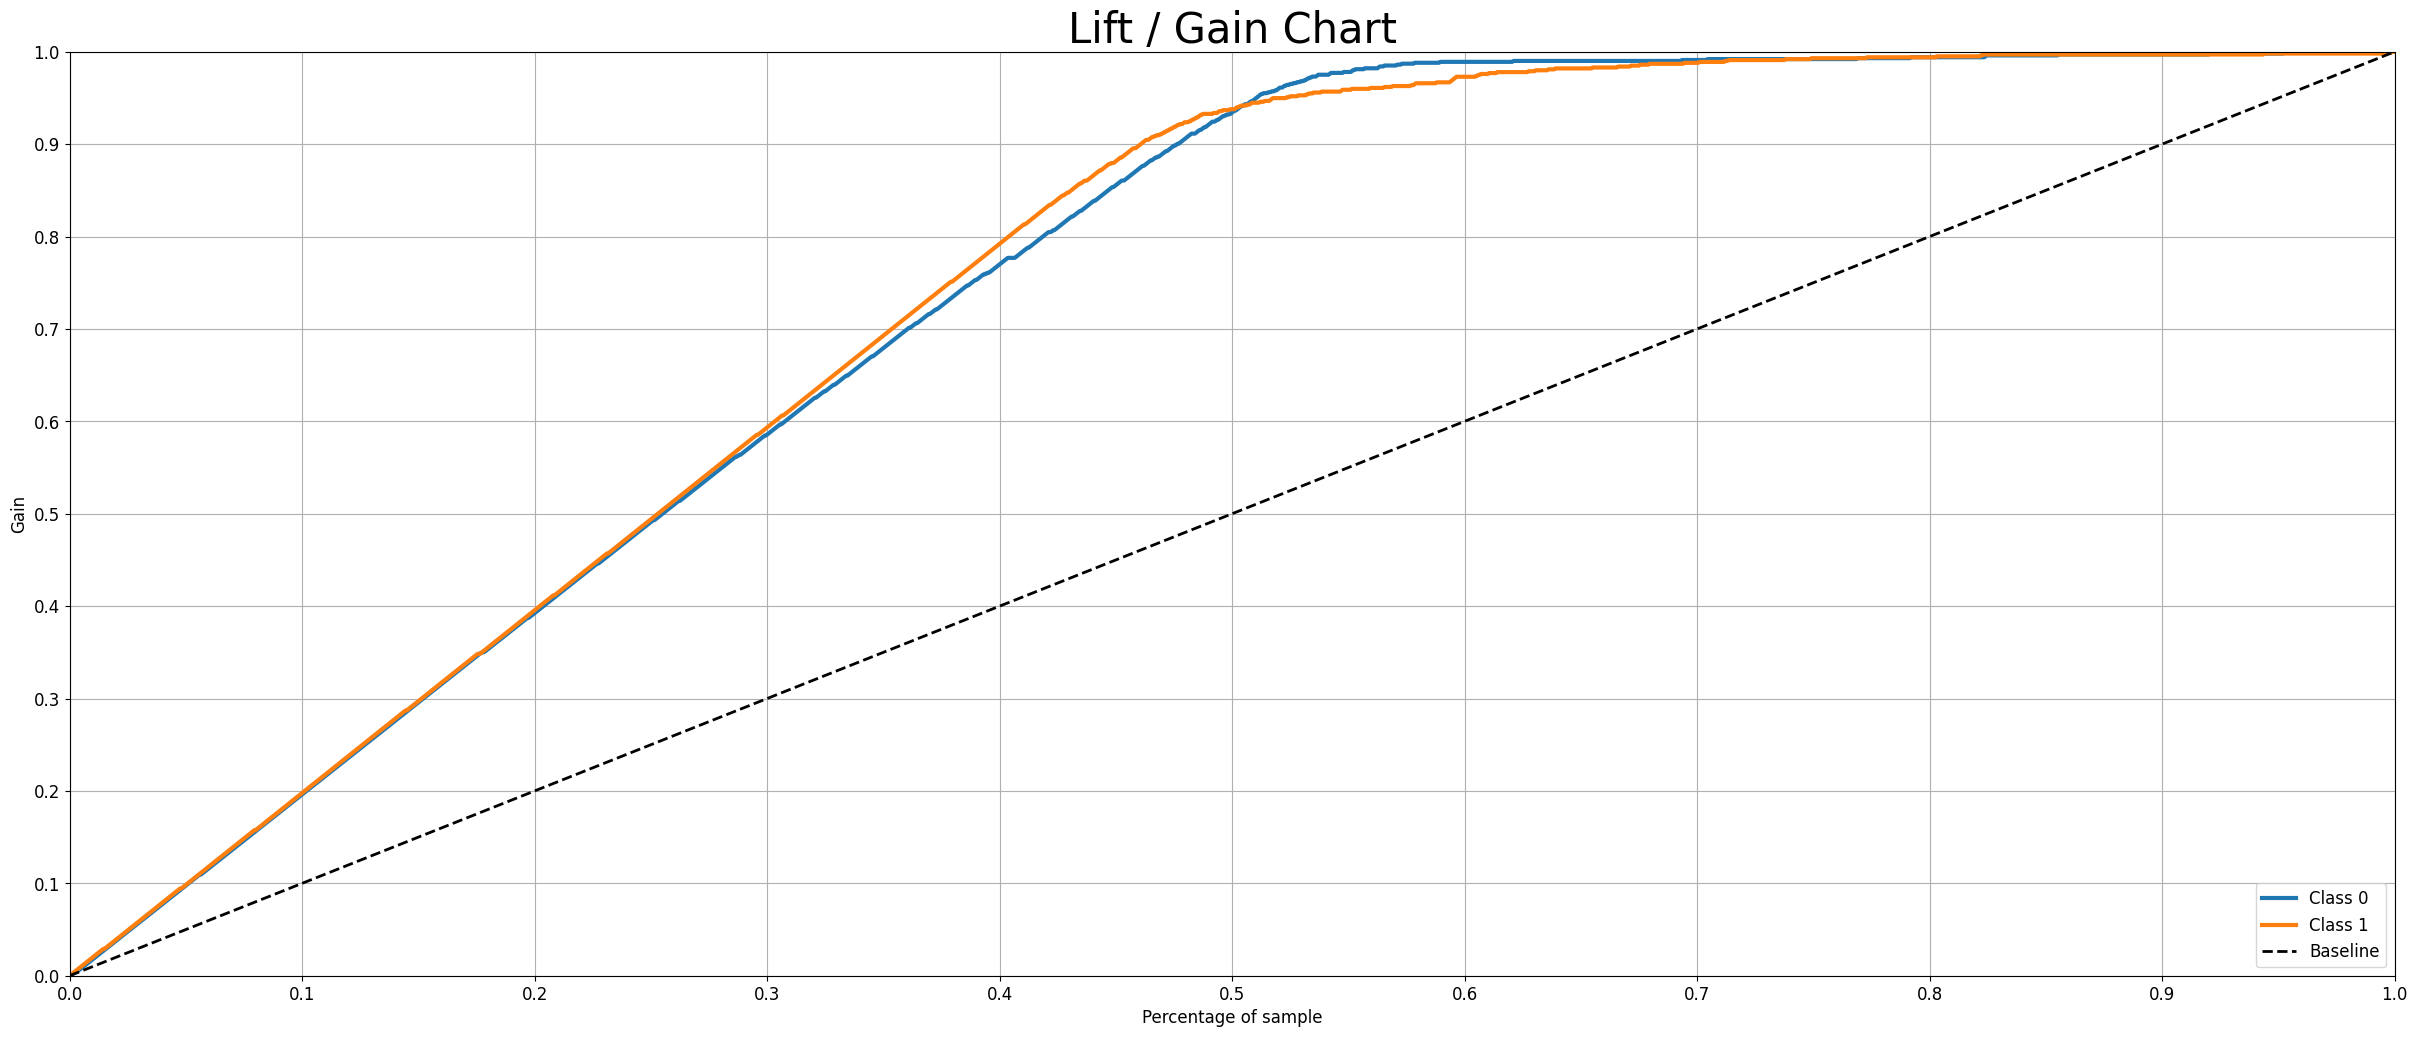

In [148]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_cumulative_gain(
    y_test,
    y_pred_proba,
    figsize=(30,12),
    title_fontsize=20,
    text_fontsize=12
)

plt.xlim([0,1])
plt.ylim([0,1])
plt.xticks(np.arange(0,1.1,step=0.1))
plt.yticks(np.arange(0,1.1,step=0.1))
plt.title("Lift / Gain Chart", size=30),
plt.rc('lines', linewidth=1.5, color='r')
plt.show()